In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import os
import tensorflow as tf
system = os.name
if system == 'posix':
    KAGGLE = True
else:
    KAGGLE = False
print(os.name)

if KAGGLE:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    for gpu_device in gpu_devices:
        print("device available:", gpu_device)

nt
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
if KAGGLE:
    !pip install ../input/keras-applications/Keras_Applications-1.0.8/ -f ./ --no-index
    !pip install ../input/image-classifiers/image_classifiers-1.0.0/ -f ./ --no-index
    !pip install ../input/efficientnet-1-0-0/efficientnet-1.0.0/ -f ./ --no-index
    !pip install ../input/segmentationmodels/ -f ./ --no-index    

In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import cv2
import sys
import json
import time
import pickle
import shutil
import numba
import numpy as np
import pandas as pd 
import tifffile as tiff
import rasterio
from rasterio.windows import Window
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.losses import bce_jaccard_loss
from tqdm import tqdm
print('tensorflow version:', tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('device available:', gpu_device)
pd.set_option('display.max_columns', None)

Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.4.1
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
TEST = False
if KAGGLE:
    TEST = True

VER = 6
DATA_PATH = f"../input/hubmap-kidney-segmentation"
if KAGGLE:
    MDL_PATH = f"../input/kidneymodel"
else:
    MDL_PATH = f"../models/models_v{VER:03}"
SUB_PATH = f"{DATA_PATH}/test" if TEST else f"{DATA_PATH}/train"
IDNT = rasterio.Affine(1, 0, 0, 0, 1, 0)
EXPAND = 4
MIN_OVERLAP = 256
STRATEGY = tf.distribute.get_strategy()
TTAS = [0]
FOLDS = [0]
THRESHOLD = 0.4
VOTERS = 1
TARGET_IMG = 'afa5e80ztu98.tiff'
start_time = time.time()
Y_SHFT = -40
X_SHFT = -24

In [6]:
with open(f"{MDL_PATH}/params.json") as file:
    PARAMS = json.load(file)
print(f"loaded params: {PARAMS}")

loaded params: {'version': 'v06', 'folds': 1, 'img_size': 256, 'resize': 4, 'batch_size': 32, 'epochs': 40, 'patience': 20, 'backbone': 'efficientnetb7', 'loss': 'bce_dice', 'mirror': False, 'umodel': 'unet', 'bce_weight': 1.0, 'shift': True, 'pseudo': '', 'lr': 0.0002, 'split': 'kfold', 'seed': None}


In [7]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) - 1
            length = int(s[2 * i + 1])
            img[start : start + length] = 1 + m
    return img.reshape(shape).T

def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

def global_shift_mask(maskpred1, y_shift, x_shift):
    """
    applies a global shift to a mask by padding
    one side and cropping from the other
    """
    if y_shift < 0 and x_shift >= 0:
        maskpred2 = np.pad(maskpred1, [(0,abs(y_shift)), (abs(x_shift), 0)], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, :maskpred1.shape[1]]
    elif y_shift >= 0 and x_shift < 0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (0, abs(x_shift))], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], abs(x_shift):]
    elif y_shift >= 0 and x_shift >= 0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (abs(x_shift), 0)], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], :maskpred1.shape[1]]
    elif y_shift < 0 and x_shift < 0:
        maskpred2 = np.pad(maskpred1, [(0, abs(y_shift)), (0, abs(x_shift))], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, abs(x_shift):]
    return maskpred3

In [8]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return params["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - params["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice",
              umodel = "unet", classes = 1, lr = 0.001):
    if backbone == "efficientnetb0":
        weights = f"{MDL_PATH}/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
    elif backbone == "efficientnetb2":
        weights = f"{MDL_PATH}/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
    elif backbone == "efficientnetb7":
        weights = f"{MDL_PATH}/efficientnet-b7_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
    else:
        raise AttributeError("backbone unknown")
    if not KAGGLE:
        weights = "imagenet"
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
        else:
            raise AttributeError("loss mode parameter error")
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = weights,
                         input_shape = input_shape,
                         classes = classes, activation = "sigmoid")
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = weights,
                        input_shape = input_shape,
                        classes = classes, activation = "sigmoid")
        else:
            raise AttributeError("umodel mode parameter error")
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr)
            ),
            loss = loss,
            metrics = [dice_coef]
        )
    return model

In [9]:
def make_grid(shape, window = 256, min_overlap = 32):
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num = nx, endpoint = False, dtype = np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num = ny, endpoint = False, dtype = np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx, ny, 4), dtype = np.int64)
    for i in range(nx):
        for j in range(ny):
            slices[i, j] = x1[i], x2[i], y1[j], y2[j]
    return slices.reshape(nx * ny, 4)


In [10]:
img_files = [x for x in os.listdir(SUB_PATH) if ".tiff" in x]
print(f"images idxs: {img_files}")

images idxs: ['0486052bb.tiff', '095bf7a1f.tiff', '1e2425f28.tiff', '26dc41664.tiff', '2f6ecfcdf.tiff', '4ef6695ce.tiff', '54f2eec69.tiff', '8242609fa.tiff', 'aaa6a05cc.tiff', 'afa5e8098.tiff', 'b2dc8411c.tiff', 'b9a3865fc.tiff', 'c68fe75ea.tiff', 'cb2d976f4.tiff', 'e79de561c.tiff']


In [11]:
subm = {}
for i_img, img_file in enumerate(img_files):
    print("-" * 20, img_file, "-" * 20)
    img_data = rasterio.open(os.path.join(SUB_PATH, img_file), transform=IDNT)
    print("img shape: ", img_data.shape)
    if img_data.count != 3:
        print("img file with subdatasets as channels")
        layers = [rasterio.open(subd) for subd in img_data.subdatasets]
    img_preds = np.zeros(img_data.shape, dtype=np.uint8)
    tile_size = int(PARAMS["img_size"] * EXPAND)
    tile_resized = int(tile_size * PARAMS["resize"])
    slices = make_grid(
        img_data.shape,
        window = tile_resized,
        min_overlap = MIN_OVERLAP
    )
    models = []
    folds = FOLDS
    for n_fold in folds:
        checkpoint_path = f"{MDL_PATH}/model_{n_fold}.hdf5"
        model = get_model(
            PARAMS["backbone"],
            input_shape = (tile_size, tile_size, 3),
            loss_type = PARAMS["loss"],
            umodel = PARAMS["umodel"]
        )
        model.load_weights(checkpoint_path)
        models.append(model)
        print("model loaded:", checkpoint_path)
    for (x1, x2, y1, y2) in tqdm(slices, desc = f"{img_file}"):
        if img_data.count == 3: #normal
            img = img_data.read(
                [1, 2, 3],
                window = Window.from_slices((x1, x2), (y1, y2))
            )
            img = np.moveaxis(img, 0, -1)
        else: # with subdatasets/layers
            img = np.zeros((tile_resized, tile_resized, 3), dtype = np.uint8)
            for fl in range(3):
                img[:, :, fl] = layers[fl].read(
                    window = Window.from_slices((x1, x2), (y1, y2))
                )
        img = cv2.resize(img, (tile_size, tile_size))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        pred = np.zeros((tile_size, tile_size), dtype = np.float32)
        for tta_mode in TTAS:
            img_aug = img
            img_aug = np.expand_dims(img_aug, 0)
            img_aug = img_aug.astype(np.float32) / 255
            pred_aug = np.zeros((tile_size, tile_size), dtype = np.float32)
            for model in models:
                pred_aug += np.squeeze(model.predict(img_aug)) / len(models)
                del  model; gc.collect()
            pred += pred_aug / len(TTAS)
        pred = cv2.resize(pred, (tile_resized, tile_resized))
        img_preds[x1:x2, y1:y2] = img_preds[x1:x2, y1:y2] + \
            (pred > THRESHOLD).astype(np.uint8)
    del models, img, pred, img_aug, pred_aug; gc.collect()
    print("img max", np.max(img_preds), "| voters:", VOTERS)
    if img_file == TARGET_IMG:
        print("global shift")
        img_preds = (img_preds >= VOTERS).astype(np.uint8)
        img_preds = global_shift_mask(img_preds, Y_SHFT, X_SHFT)
    else:
        img_preds = (img_preds >= VOTERS).astype(np.uint8)
    rle_pred = rle_encode_less_memory(img_preds)
    subm[i_img] = {"id": img_file.replace(".tiff", ""), "predicted": rle_pred}
    del img_preds, img_data, rle_pred; gc.collect()

elapsed_time = time.time() - start_time
print(f"time elapsed: {elapsed_time // 60:.0f} min {elapsed_time % 60:.0f} sec")

-------------------- 0486052bb.tiff --------------------
img shape:  (25784, 34937)


0486052bb.tiff:   0%|                                                                           | 0/70 [00:00<?, ?it/s]

model loaded: ../models/models_v006/model_0.hdf5


0486052bb.tiff: 100%|██████████████████████████████████████████████████████████████████| 70/70 [00:38<00:00,  1.79it/s]


img max 4 | voters: 1
-------------------- 095bf7a1f.tiff --------------------
img shape:  (38160, 39000)
img file with subdatasets as channels


095bf7a1f.tiff:   0%|                                                                          | 0/110 [00:00<?, ?it/s]

model loaded: ../models/models_v006/model_0.hdf5


095bf7a1f.tiff: 100%|████████████████████████████████████████████████████████████████| 110/110 [00:49<00:00,  2.21it/s]


img max 4 | voters: 1
-------------------- 1e2425f28.tiff --------------------
img shape:  (26780, 32220)
img file with subdatasets as channels


1e2425f28.tiff:   0%|                                                                           | 0/63 [00:00<?, ?it/s]

model loaded: ../models/models_v006/model_0.hdf5


1e2425f28.tiff:   2%|█                                                                  | 1/63 [00:02<02:51,  2.77s/it]


KeyboardInterrupt: 

In [12]:
df_sub = pd.DataFrame(subm).T
df_sub

,id,predicted
0,0486052bb,102011282 53 102037059 70 102062839 80 1020885...
1,095bf7a1f,118239054 15 118239107 13 118277206 79 1183153...


In [13]:
df_sub.to_csv("submission.csv", index = False)

(3, 38160, 39000)
(38160, 39000, 3)
(38160, 39000)
(38160, 39000)


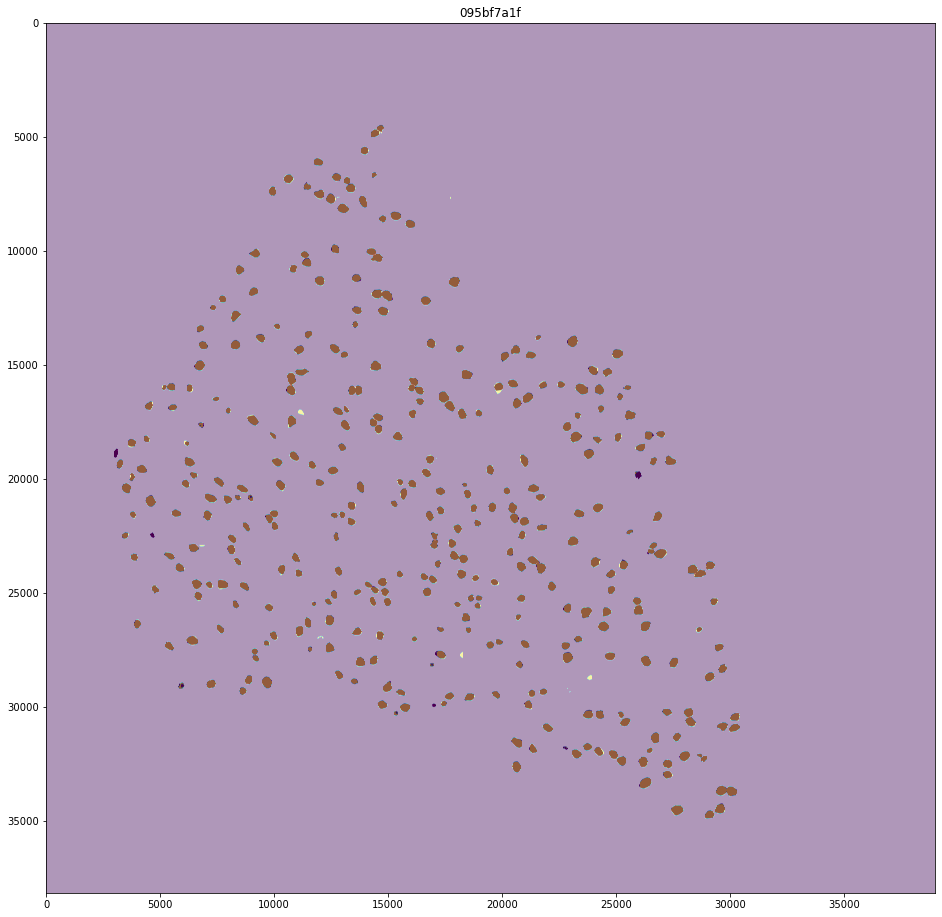

time elapsed: 5 min, 52 sec


In [14]:
i = 1
if not KAGGLE:
    if not TEST:
        df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")
        idx = df_sub.iloc[i].id
        img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
        print(img.shape)
        if img.shape[0] == 3: img = np.transpose(img.squeeze(), (1, 2, 0))
        msk_p = enc2mask([df_sub.iloc[i].predicted], (img.shape[1], img.shape[0]))
        msk = enc2mask([df_masks.loc[idx, "encoding"]], (img.shape[1], img.shape[0]))
        print(img.shape)
        print(msk_p.shape)
        print(msk.shape)
        
        #plt.figure(figsize = (16, 16))
        #plt.imshow(img)
        #plt.imshow(msk, alpha = 0.3)
        #plt.title(idx)
        #plt.show()
        
        #plt.figure(figsize = (16, 16))
        #plt.figure(figsize = (16, 16))
        #plt.imshow(img)
        #plt.imshow(msk_p, alpha = 0.3)
        #plt.title(idx)
        #plt.show()
        
        plt.figure(figsize = (16, 16))
        plt.imshow(msk, alpha = 1, cmap = "BuPu")
        plt.imshow(msk_p, alpha = 0.4)
        plt.title(idx)
        plt.savefig(f'{MDL_PATH}/{idx}-{int(time.time())}.jpeg', transparent=True, bbox_inches = 'tight',
                            facecolor = 'k',pad_inches = 0)
        plt.show()
    else:
        idx = df_sub.iloc[0].id
        img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
        if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
        msk_p = enc2mask([df_sub.iloc[0].predicted], (img.shape[1], img.shape[0]))
        print(img.shape)
        print(msk_p.shape)
        plt.figure(figsize = (16, 16))
        plt.imshow(img)
        plt.imshow(msk_p, alpha = 0.4)
        plt.title(idx)
        plt.show()
    elapsed_time = time.time() - start_time
    print(f"time elapsed: {elapsed_time // 60:.0f} min, {elapsed_time % 60:.0f} sec")